# Training strategies

In [1]:
import copy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


data: pd.DataFrame = pd.read_csv('datasets/heart_failure_clinical_records_dataset.csv')
original_data = copy.deepcopy(data)
target = 'DEATH_EVENT'
positive = 1
negative = 0
print(data['DEATH_EVENT'].value_counts())
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels: np.ndarray = pd.unique(y)

0    203
1     96
Name: DEATH_EVENT, dtype: int64


{'Original': [96, 203], 'Train': [67, 142], 'Test': [29, 61]}


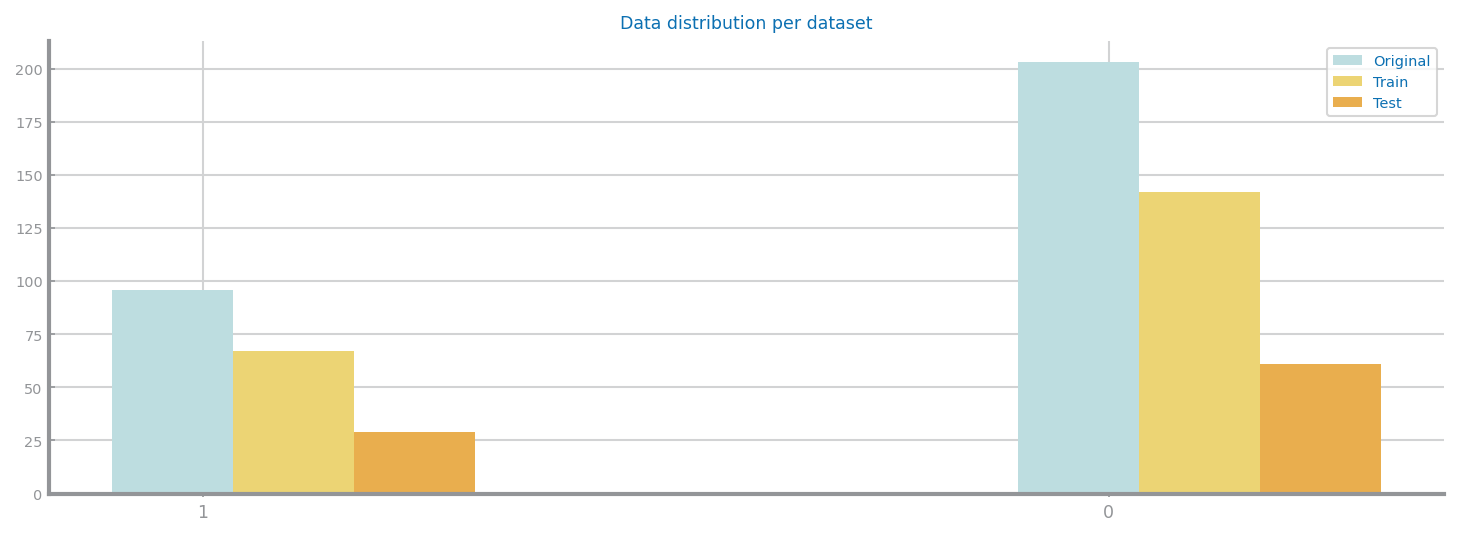

In [3]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]
plt.figure(figsize=(12,4))
print(values)
ds.multiple_bar_chart([positive , negative], values, title='Data distribution per dataset')
plt.show()

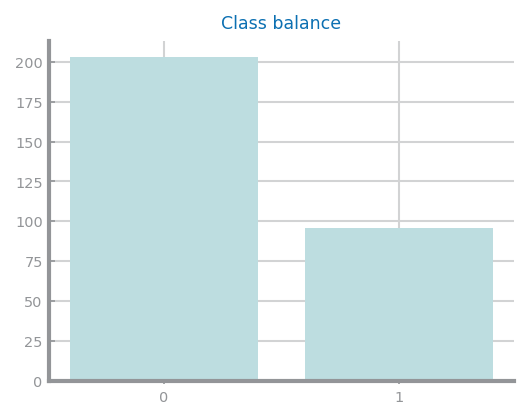

DEATH_EVENT = 1 Minority class: 96
DEATH_EVENT = 0 Majority class: 203
Proportion: 0.47 : 1


In [3]:
target_count = original_data['DEATH_EVENT'].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.xticks([0,1])
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('DEATH_EVENT = 1 Minority class:', target_count[ind_min_class])
print('DEATH_EVENT = 0 Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 2), ': 1')

More than half of the are records are 0, making it slightly unbalanced. So in order to make it easier for the training we should balance the data.
Taking into consideration that we are in the presence of a small number of positive records, we need to appy oversampling, in order to create a larger set to support the training step. Among the different oversampling techniques we followed the recommended SMOTE rule.

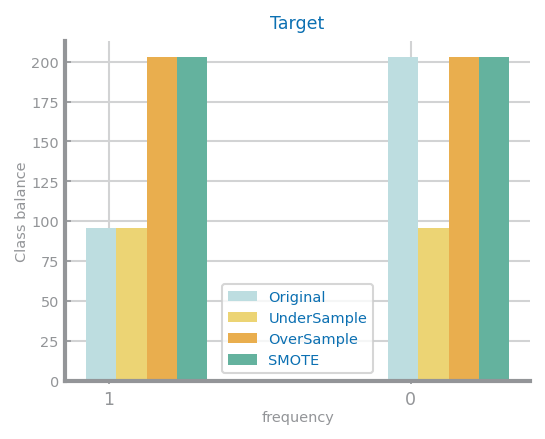

In [6]:
RANDOM_STATE = 42
values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

df_class_min = original_data[original_data['DEATH_EVENT'] == min_class]
df_class_max = original_data[original_data['DEATH_EVENT'] != min_class]

df_under = df_class_max.sample(len(df_class_min))
values['UnderSample'] = [target_count.values[ind_min_class], len(df_under)]

df_over = df_class_min.sample(len(df_class_max), replace=True)
values['OverSample'] = [len(df_over), target_count.values[1-ind_min_class]]

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = original_data.pop('DEATH_EVENT').values
X = original_data.values
smote_X, smote_y = smote.fit_sample(X, y)
smote_target_count = pd.Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

fig = plt.figure()
ds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance')
plt.show()

# Scaling

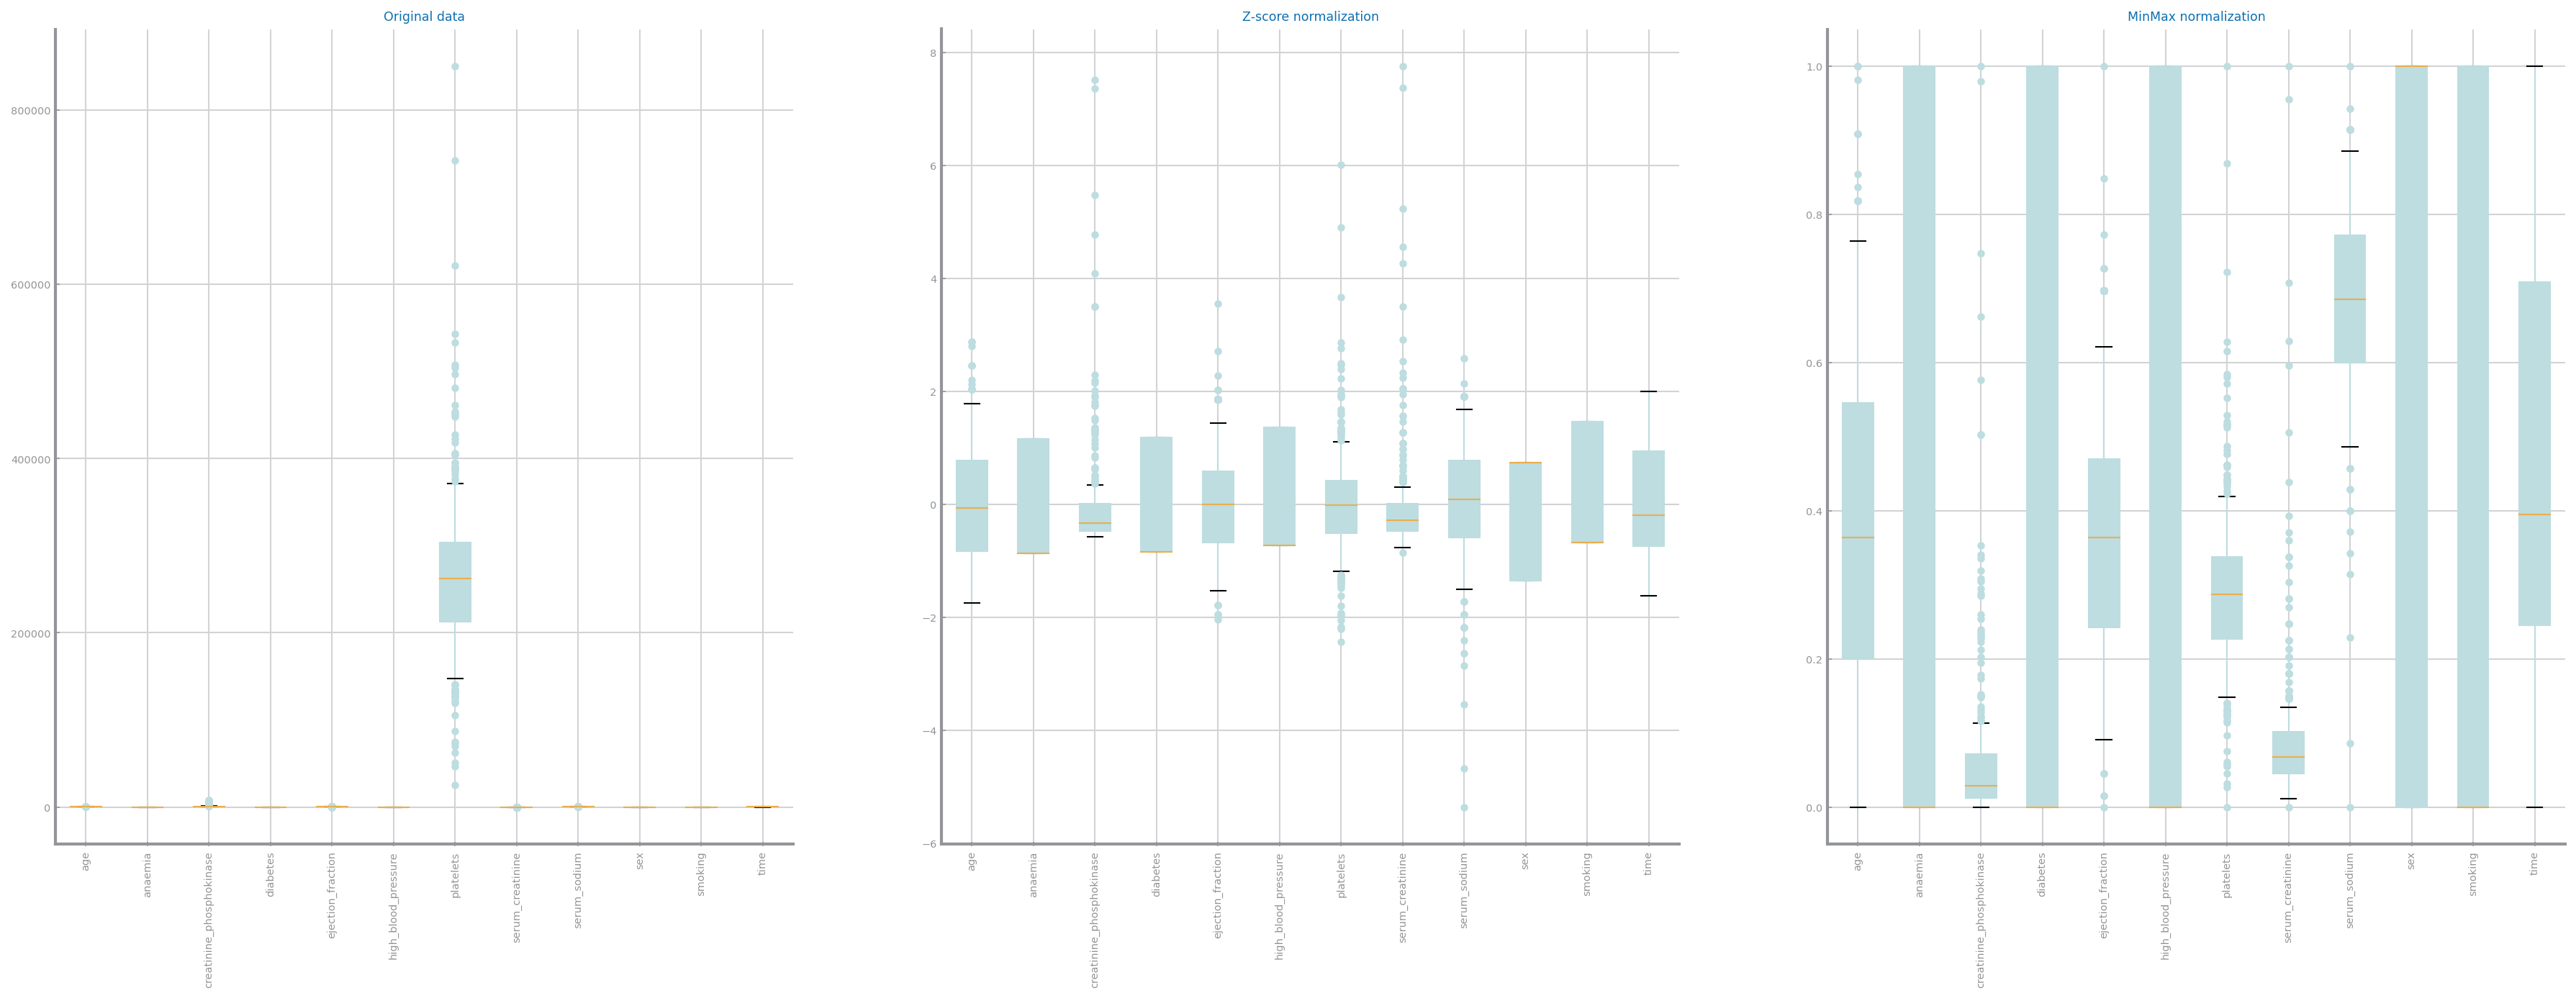

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(data)
df_nr = pd.DataFrame(transf.transform(data), columns= data.columns)
norm_data_zscore = df_nr
norm_data_zscore.describe(include='all')

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_minmax = df_nr
norm_data_minmax.describe(include='all')

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(30,10),squeeze=False )
axs[0, 0].set_title('Original data')
data.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title('MinMax normalization')
# axs[0, 2].xticks(rotation=90)
norm_data_minmax.boxplot(ax=axs[0, 2])
# fig.tight_layout()
for i in range(3):
    plt.setp(axs[0, i].xaxis.get_majorticklabels(), rotation=90)
    
plt.show()

Below we can find the boxplots with higher resolution.

In [5]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

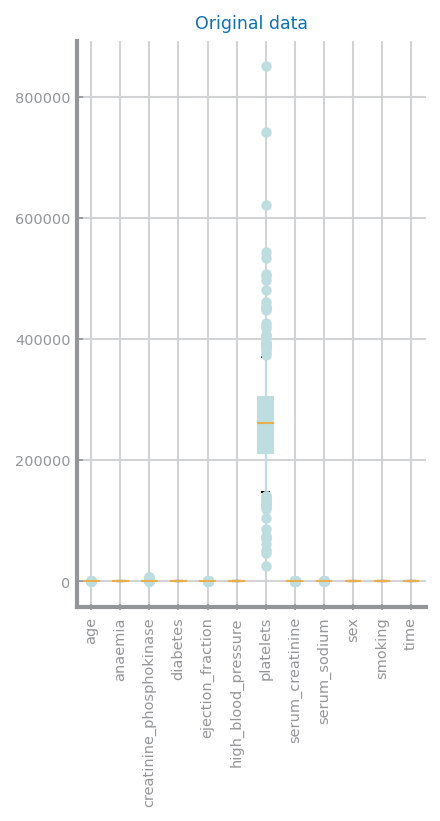

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(3,5),squeeze=False )
axs[0, 0].set_title('Original data')
data.boxplot(ax=axs[0, 0])
plt.xticks(rotation=90)    
plt.show()

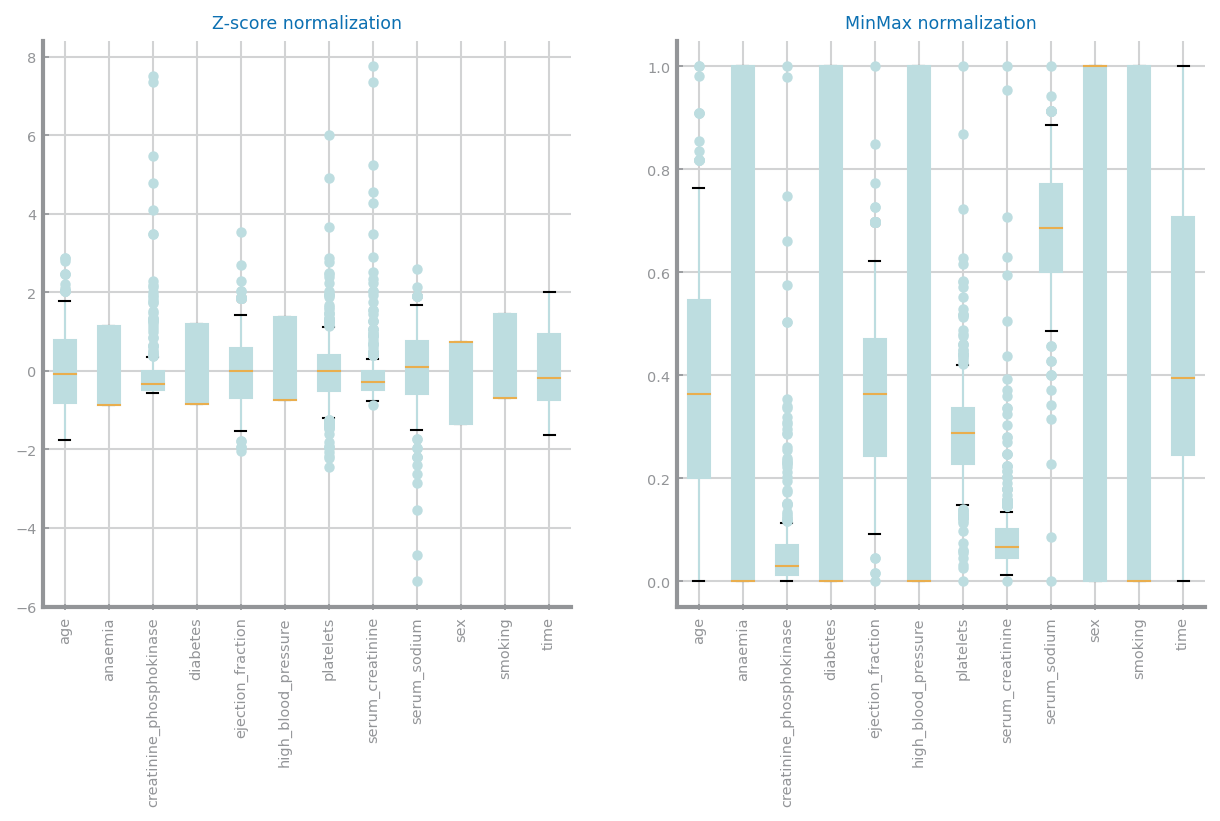

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10,5),squeeze=False )
axs[0, 0].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('MinMax normalization')
# axs[0, 2].xticks(rotation=90)
norm_data_minmax.boxplot(ax=axs[0, 1])
# fig.tight_layout()
for i in range(2):
    plt.setp(axs[0, i].xaxis.get_majorticklabels(), rotation=90)
    
plt.show()

As shown above, after MinMax normalization the new attribute takes on values in the range [0, 1]. Because all attributes were already between 0 and 1, each value was not restrictly scaled by the sample range. Conversely, after the Z-score normalization, the new attributes have mean equal to 0 and standard deviation 1.

# Naive Bayes

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.naive_bayes import *
import ds_functions as ds

data: pd.DataFrame = pd.read_csv('datasets/heart_failure_clinical_records_dataset.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

clf = GaussianNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)


<li><b>Accuracy:</b> Ratio of correct predictions to total predictions made.
    <p>\begin{equation*}
            \frac{TN + TP}{TN + TP + FP + FN}
        \end{equation*}
    </li>
<li><b>Recall:</b> Of all our positive class, how correct was our prediction.
    <p>\begin{equation*}
            \frac{TP}{TP+FN}
        \end{equation*}
    </li>
    <li><b>Specificity:</b> True negative rate.
    <p>\begin{equation*}
            \frac{TN}{TN+FP}
        \end{equation*}
    </li>
   <li><b>Precision:</b> Of all our positive class we predict which one is really positive.
    <p>\begin{equation*}
            \frac{TP}{TP+FP}
        \end{equation*}
   </li>

Confusion Matrix Test
TruePositives:  14
FalsePositives:  4
TrueNegatives:  57
FalseNegatives:  15


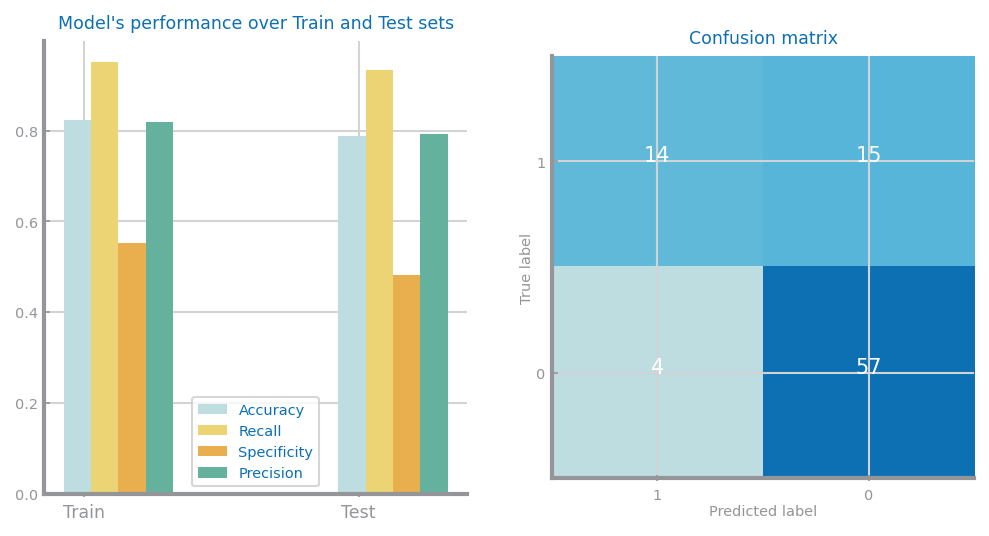

In [10]:
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

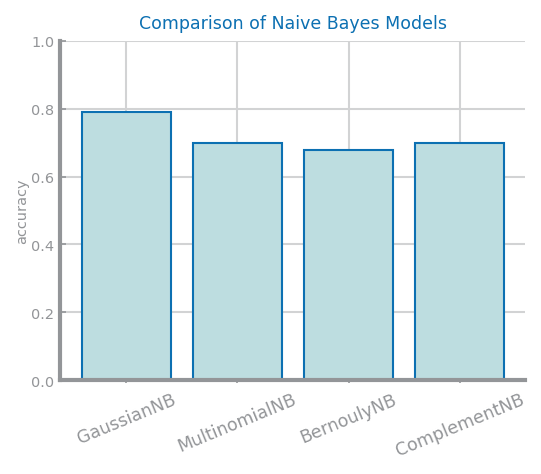

In [11]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulyNB': BernoulliNB(),
              'ComplementNB': ComplementNB()
            }

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.xticks(rotation=22.5)
plt.show()

* GaussianNB: implements the Gaussian Naive Bayes algorithm for classification, wherein the likelihood of the features is assumed to be Gaussian
* MultinomialNB: implements the naive Bayes algorithm for multinomially distributed data, suitable for classification with discrete features
* BernoulyNB: implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions, ie, there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable
* ComplementNB: implements the complement naive Bayes algorithm, an adaptation of the standard multinomial naive Bayes using statistics from the complement of each class to compute the model’s weights

From the aforementioned described models, it follows that Gaussian algorithm has a higher accuracy since each one of the numeric attributes is normally distributed for each class.

# KNN

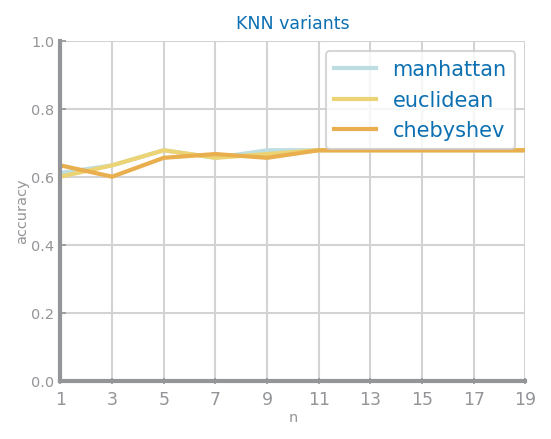

Best results with 5 neighbors and manhattan


In [27]:
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier

labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

Confusion Matrix Test
TruePositives:  7
FalsePositives:  7
TrueNegatives:  54
FalseNegatives:  22


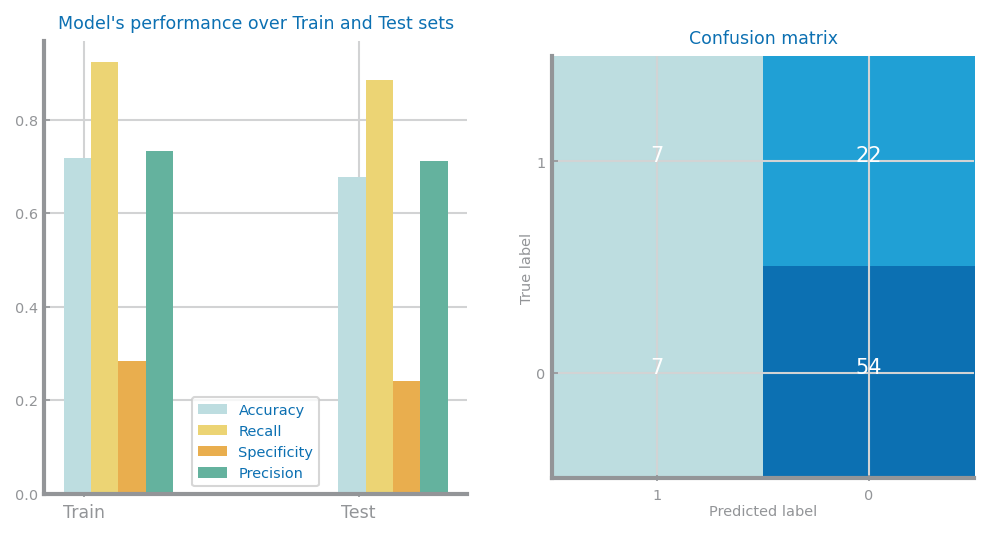

In [28]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)